In [2]:
import sys
import os

# Get the absolute path of the parent directory
parent_dir = os.path.abspath('..')
# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


## Pipeline

### Function: `run_pipeline`

#### Description:
The `run_pipeline` function starts the machine learning pipeline, taking in both original and synthetic data for training and evaluation. It allows for custom configurations like test size and synthesis-related parameters, with defaults provided for some parameters.

#### Parameters:
- `original_dataset_path` (str): Path to the dataset file (e.g., CSV).
- `separator` (str): The delimiter used in the dataset (e.g., `","`, `"\t"`).
- `target_column` (str): The name of the column representing the target variable to predict.
- `test_size` (float, optional): Proportion of the dataset to use for testing. Default is `0.2`.
- `random_state` (int, optional): Seed for reproducibility. Default is `42`.
- `epochs` (int, optional): Number of iterations for synthetic data generation or model training. Default is `50`.
- `batch_size` (int, optional): Size of each batch during synthetic data generation or training. Default is `32`.

#### Returns:
- `results_df` (DataFrame): A DataFrame containing performance metrics (e.g., accuracy, precision, recall) for the models evaluated on the dataset.


In [3]:
from src.dataOperations.synthetic_data_operations import generate_synthetic_data
from src.dataOperations.synthetic_data_operations import evaluate_synthetic_data

from src.modelOperations.ml_data_preprocessing import prepare_original_data, prepare_synthetic_data, encode_categorical_features
from src.modelOperations.model_training import train_models, evaluate_models
from src.visualization.result_visualization import visualize_model_performance


def run_pipeline(
    original_dataset_path,
    separator,
    target_column,
    test_size=0.2,
    random_state=42,
    epochs=50,  # Number of iterations for training the synthetic data generator
    batch_size=32,  # Batch size for synthetic data generation or training models
):
    # Step 1: Generate synthetic data
    synthetic_data, metadata, original_data, dataset_name = generate_synthetic_data(original_dataset_path, separator)

    # **NEW STEP: ENCODE CATEGORICAL FEATURES IN ORIGINAL AND SYNTHETIC DATA**
    original_data = encode_categorical_features(original_data, target_column)
    synthetic_data = encode_categorical_features(synthetic_data, target_column)

    # Step 2: Prepare datasets
    X_train_original, X_test_original, y_train_original, y_test_original = prepare_original_data(
        original_data, target_column, test_size=test_size, random_state=random_state
    )
    X_synthetic, y_synthetic = prepare_synthetic_data(synthetic_data, target_column)

    print(f"Original Data - Training Size: {len(X_train_original)}, Testing Size: {len(X_test_original)}")
    print(f"Synthetic Data - Training Size: {len(X_synthetic)}, Testing Size: 0 (Synthetic data is not split into test sets)")

    print(f"Number of features after encoding: {X_train_original.shape[1]}")
    print(f"Class distribution in training data (Original): {y_train_original.value_counts(normalize=True).to_dict()}")
    print(f"Class distribution in synthetic data: {y_synthetic.value_counts(normalize=True).to_dict()}")
 
    # Combine original and synthetic datasets
    datasets = {
        'Original': (X_train_original, y_train_original),
        'Synthetic': (X_synthetic, y_synthetic)
    }

    # Step 3: Train models
    trained_models = train_models(datasets)

    # Step 4: Evaluate models
    results_df = evaluate_models(trained_models, X_test_original, y_test_original, datasets)

    # Step 5: Visualize results
    visualize_model_performance(results_df, dataset_name)

    return results_df







Processing dataset: studentPerformance
Original dataset size: 4424 rows
Dropped 0 rows due to missing values

Found existing synthesizer for studentPerformance at: ../src/synthesizers\studentPerformance_synthesizer.pkl
Loading synthesizer...
Synthesizer loaded successfully

Using synthesizer 'studentPerformance_synthesizer' to generate synthetic data for dataset 'studentPerformance'
Synthetic data generated successfully: 3539 rows created
Identified categorical columns for encoding: []
No categorical columns found. Skipping encoding.
Identified categorical columns for encoding: []
No categorical columns found. Skipping encoding.
Original Data - Training Size: 3539, Testing Size: 885
Synthetic Data - Training Size: 3539, Testing Size: 0 (Synthetic data is not split into test sets)
Number of features after encoding: 36
Class distribution in training data (Original): {'Graduate': 0.5060751624752755, 'Dropout': 0.3122350946595083, 'Enrolled': 0.18168974286521616}
Class distribution in syn

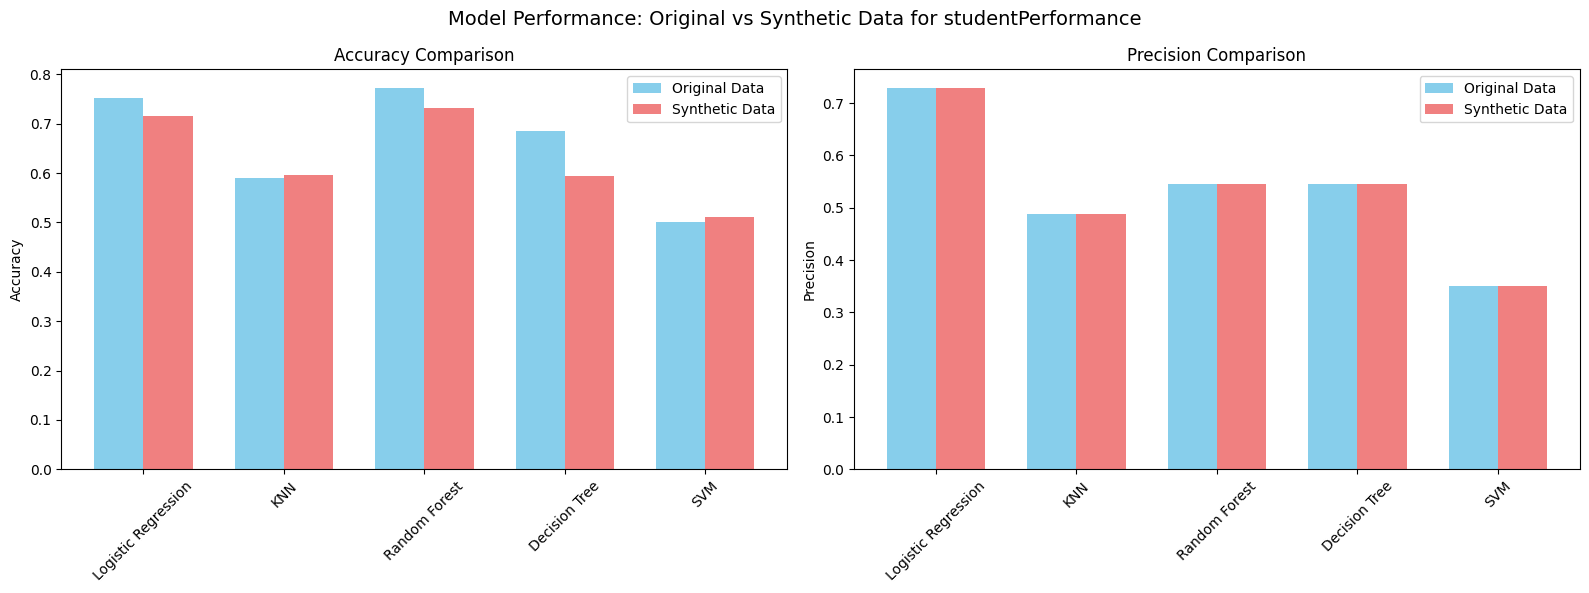


Detailed Model Performance Comparison:
  Dataset               Model  Accuracy  Precision  Recall     F1
 Original Logistic Regression    0.7525     0.7283  0.6712 0.6108
 Original                 KNN    0.5894     0.4890  0.5254 0.4969
 Original       Random Forest    0.7714     0.5447  0.6542 0.5942
 Original       Decision Tree    0.6855     0.5463  0.5514 0.5421
 Original                 SVM    0.5013     0.3512  0.4588 0.3393
Synthetic Logistic Regression    0.7155     0.7283  0.6712 0.6108
Synthetic                 KNN    0.5968     0.4890  0.5254 0.4969
Synthetic       Random Forest    0.7318     0.5447  0.6542 0.5942
Synthetic       Decision Tree    0.5948     0.5463  0.5514 0.5421
Synthetic                 SVM    0.5106     0.3512  0.4588 0.3393


,Dataset,Model,Accuracy,Precision,Recall,F1
0,Original,Logistic Regression,0.7525,0.7283,0.6712,0.6108
1,Original,KNN,0.5894,0.4890,0.5254,0.4969
2,Original,Random Forest,0.7714,0.5447,0.6542,0.5942
3,Original,Decision Tree,0.6855,0.5463,0.5514,0.5421
4,Original,SVM,0.5013,0.3512,0.4588,0.3393
5,Synthetic,Logistic Regression,0.7155,0.7283,0.6712,0.6108
6,Synthetic,KNN,0.5968,0.4890,0.5254,0.4969
7,Synthetic,Random Forest,0.7318,0.5447,0.6542,0.5942
8,Synthetic,Decision Tree,0.5948,0.5463,0.5514,0.5421
9,Synthetic,SVM,0.5106,0.3512,0.4588,0.3393


In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
original_dataset_path = "../datasets/original/studentPerformance.csv"
separator = ';'
target_column = 'Target'
# TEMPORARY SOLUTION: Suppress ConvergenceWarning and UndefinedMetricWarning until model tuning is done
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

run_pipeline(
original_dataset_path,
separator,
target_column
)


Processing dataset: bankMarketing
Original dataset size: 45211 rows
Dropped 0 rows due to missing values

Found existing synthesizer for bankMarketing at: ../src/synthesizers\bankMarketing_synthesizer.pkl
Loading synthesizer...
Synthesizer loaded successfully

Using synthesizer 'bankMarketing_synthesizer' to generate synthetic data for dataset 'bankMarketing'
Synthetic data generated successfully: 45211 rows created
Identified categorical columns for encoding: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Starting one-hot encoding...
Encoding complete. Dataset now has 43 columns.
Identified categorical columns for encoding: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Starting one-hot encoding...
Encoding complete. Dataset now has 43 columns.

Training models...

Training models on Original dataset:
Training Logistic Regression...
Logistic Regression trained successfully.
Training KNN...
K

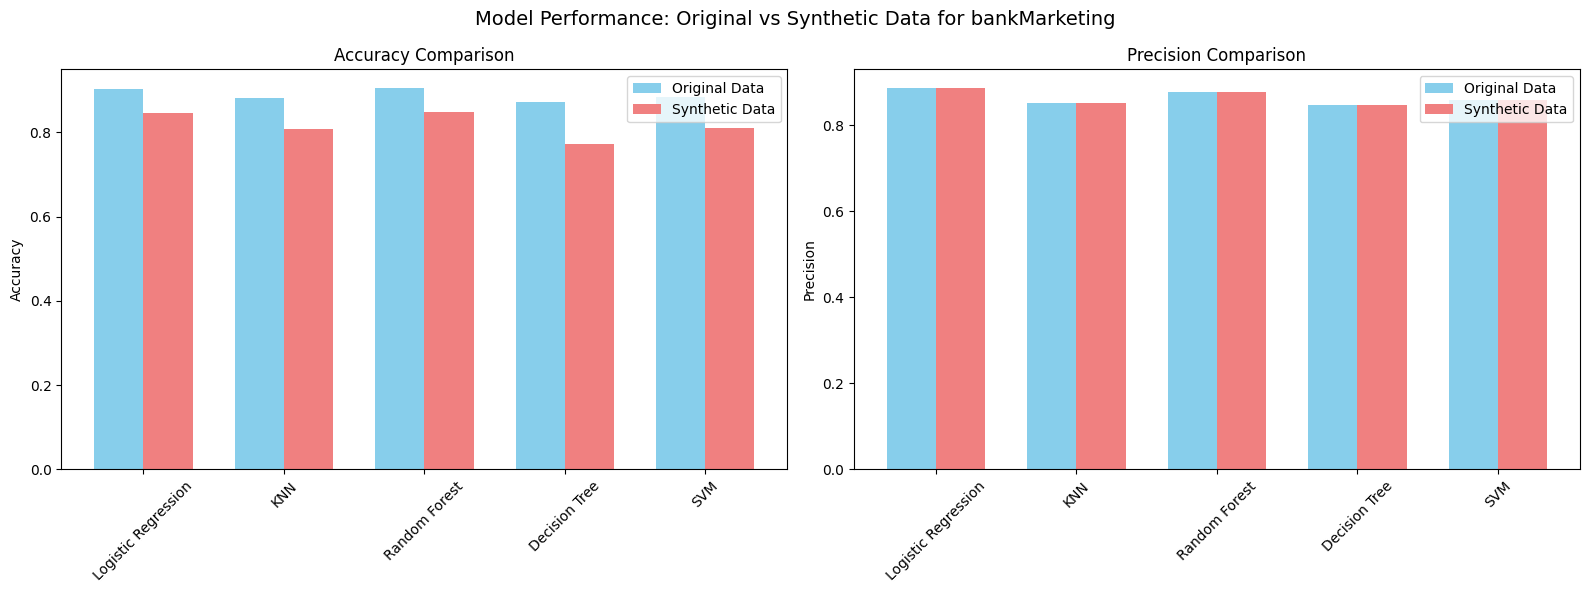


Detailed Model Performance Comparison:
  Dataset               Model  Accuracy  Precision  Recall     F1
 Original Logistic Regression    0.9021     0.8860  0.8935 0.8891
 Original                 KNN    0.8817     0.8511  0.8510 0.8511
 Original       Random Forest    0.9047     0.8775  0.8875 0.8815
 Original       Decision Tree    0.8713     0.8463  0.7873 0.8108
 Original                 SVM    0.8842     0.8594  0.8855 0.8580
Synthetic Logistic Regression    0.8459     0.8860  0.8935 0.8891
Synthetic                 KNN    0.8084     0.8511  0.8510 0.8511
Synthetic       Random Forest    0.8482     0.8775  0.8875 0.8815
Synthetic       Decision Tree    0.7737     0.8463  0.7873 0.8108
Synthetic                 SVM    0.8108     0.8594  0.8855 0.8580


,Dataset,Model,Accuracy,Precision,Recall,F1
0,Original,Logistic Regression,0.9021,0.8860,0.8935,0.8891
1,Original,KNN,0.8817,0.8511,0.8510,0.8511
2,Original,Random Forest,0.9047,0.8775,0.8875,0.8815
3,Original,Decision Tree,0.8713,0.8463,0.7873,0.8108
4,Original,SVM,0.8842,0.8594,0.8855,0.8580
5,Synthetic,Logistic Regression,0.8459,0.8860,0.8935,0.8891
6,Synthetic,KNN,0.8084,0.8511,0.8510,0.8511
7,Synthetic,Random Forest,0.8482,0.8775,0.8875,0.8815
8,Synthetic,Decision Tree,0.7737,0.8463,0.7873,0.8108
9,Synthetic,SVM,0.8108,0.8594,0.8855,0.8580


In [19]:
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

# TEMPORARY SOLUTION: Suppress ConvergenceWarning and UndefinedMetricWarning until model tuning is done
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

original_dataset_path = "../datasets/original/bankMarketing.csv"
separator = ';'
target_column = 'y'

run_pipeline(
original_dataset_path,
separator,
target_column
)

In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

# TEMPORARY SOLUTION: Suppress ConvergenceWarning and UndefinedMetricWarning until model tuning is done
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

original_dataset_path = "../datasets/original/loan.csv"
separator = ';'
target_column = 'LoanAmount'

run_pipeline(
original_dataset_path,
separator,
target_column
)


Processing dataset: loan
Original dataset size: 614 rows
Dropped 0 rows due to missing values

Found existing synthesizer for loan at: ../src/synthesizers\loan_synthesizer.pkl
Loading synthesizer...
Synthesizer loaded successfully

Using synthesizer 'loan_synthesizer' to generate synthetic data for dataset 'loan'
Synthetic data generated successfully: 491 rows created
Identified categorical columns for encoding: ['Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status']
Starting one-hot encoding...
Encoding complete. Dataset now has 613 columns.
Identified categorical columns for encoding: ['Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status']
Starting one-hot encoding...
Encoding complete. Dataset now has 490 columns.


KeyError: "['LoanAmount'] not found in axis"


Processing dataset: studentMathScores
Original dataset size: 395 rows
Dropped 0 rows due to missing values

Found existing synthesizer for studentMathScores at: ../src/synthesizers\studentMathScores_synthesizer.pkl
Loading synthesizer...
Synthesizer loaded successfully

Using synthesizer 'studentMathScores_synthesizer' to generate synthetic data for dataset 'studentMathScores'
Synthetic data generated successfully: 316 rows created
Identified categorical columns for encoding: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Starting one-hot encoding...
Encoding complete. Dataset now has 42 columns.
Identified categorical columns for encoding: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Starting one-hot encoding...
Encoding c

c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Completed Logistic Regression evaluation.

Processing KNN...
Completed KNN evaluation.

Processing Random Forest...


c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Completed Random Forest evaluation.

Processing Decision Tree...
Completed Decision Tree evaluation.

Processing SVM...
Completed SVM evaluation.

Evaluating models trained on Synthetic dataset:

Processing Logistic Regression...


c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Completed Logistic Regression evaluation.

Processing KNN...
Completed KNN evaluation.

Processing Random Forest...


c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Completed Random Forest evaluation.

Processing Decision Tree...
Completed Decision Tree evaluation.

Processing SVM...
Completed SVM evaluation.

Model Performance Comparison:
  Dataset               Model  Accuracy  Precision  Recall     F1
 Original Logistic Regression    0.3609     0.0875  0.0886 0.0809
 Original                 KNN    0.3197     0.0688  0.0633 0.0542
 Original       Random Forest    0.4116     0.0468  0.0506 0.0455
 Original       Decision Tree    0.4337     0.0556  0.0380 0.0450
 Original                 SVM    0.3039     0.0042  0.0506 0.0077
Synthetic Logistic Regression    0.0476     0.0875  0.0886 0.0809
Synthetic                 KNN    0.0727     0.0688  0.0633 0.0542
Synthetic       Random Forest    0.0919     0.0468  0.0506 0.0455
Synthetic       Decision Tree    0.0729     0.0556  0.0380 0.0450
Synthetic                 SVM    0.1043     0.0042  0.0506 0.0077


c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\delea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


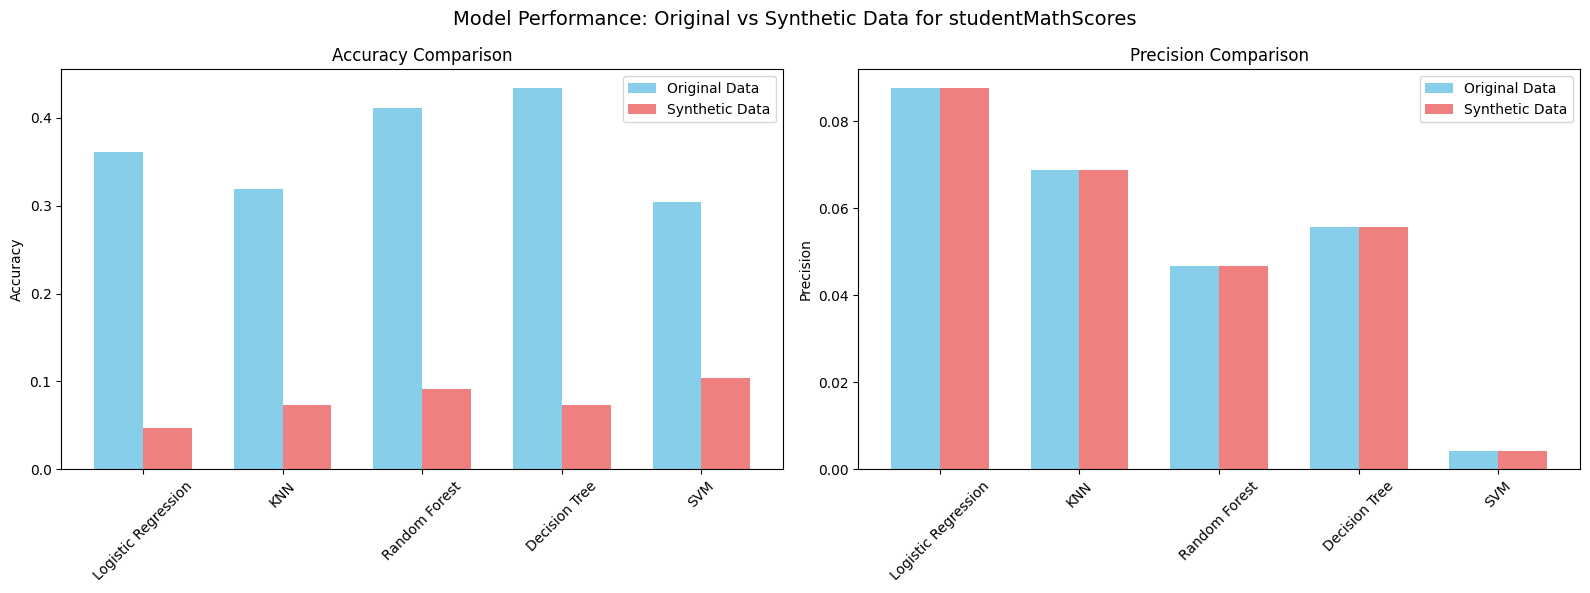


Detailed Model Performance Comparison:
  Dataset               Model  Accuracy  Precision  Recall     F1
 Original Logistic Regression    0.3609     0.0875  0.0886 0.0809
 Original                 KNN    0.3197     0.0688  0.0633 0.0542
 Original       Random Forest    0.4116     0.0468  0.0506 0.0455
 Original       Decision Tree    0.4337     0.0556  0.0380 0.0450
 Original                 SVM    0.3039     0.0042  0.0506 0.0077
Synthetic Logistic Regression    0.0476     0.0875  0.0886 0.0809
Synthetic                 KNN    0.0727     0.0688  0.0633 0.0542
Synthetic       Random Forest    0.0919     0.0468  0.0506 0.0455
Synthetic       Decision Tree    0.0729     0.0556  0.0380 0.0450
Synthetic                 SVM    0.1043     0.0042  0.0506 0.0077


,Dataset,Model,Accuracy,Precision,Recall,F1
0,Original,Logistic Regression,0.3609,0.0875,0.0886,0.0809
1,Original,KNN,0.3197,0.0688,0.0633,0.0542
2,Original,Random Forest,0.4116,0.0468,0.0506,0.0455
3,Original,Decision Tree,0.4337,0.0556,0.0380,0.0450
4,Original,SVM,0.3039,0.0042,0.0506,0.0077
5,Synthetic,Logistic Regression,0.0476,0.0875,0.0886,0.0809
6,Synthetic,KNN,0.0727,0.0688,0.0633,0.0542
7,Synthetic,Random Forest,0.0919,0.0468,0.0506,0.0455
8,Synthetic,Decision Tree,0.0729,0.0556,0.0380,0.0450
9,Synthetic,SVM,0.1043,0.0042,0.0506,0.0077


In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

# TEMPORARY SOLUTION: Suppress ConvergenceWarning and UndefinedMetricWarning until model tuning is done
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

original_dataset_path = "../datasets/original/studentMathScores.csv"
separator = ';'
target_column = 'G3'

run_pipeline(
original_dataset_path,
separator,
target_column
)